### Notebook to train a LSTM for system dynamics using an advection-aware autoencoder trained with parametric 1D Burgers equation snapshots  

Consider the one-dimensional viscous Burgers' equation with Dirichlet boundary conditions which can be represented as 
\begin{align}
\dot{u} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2},\\
u(x,0) = u_0, \qquad x \in [0,L], \qquad u(0,t) = u(L.t) = 0
\end{align}

Consider the initial condition
\begin{align}
u(x,0) = \frac{x}{1 + \sqrt{\frac{1}{t_0}} \exp{\left(Re \frac{x^2}{4} \right)}},
\end{align}

Set $L=1$ and maximum time $t_{max} = 2$. An analytical solution exists and is given by 
\begin{align}
u(x,t) =  \frac{\frac{x}{t+1}}{1 + \sqrt{\frac{t+1}{t_0}} \exp{\left(Re \frac{x^2}{4t+4} \right)}}
\end{align}

where $t_0 = \exp{(Re/8)}$ and $Re = 1/\nu$. 
The spatio-temporal domain $[0,L]\times[0,t_{max}]$ is uniformly discretized into $200$ grid points and $500$ time points.

In [2]:
## Load modules
%matplotlib inline

import numpy as np
from numpy import array
import scipy
import os
import gc
import argparse
import time
import importlib
from importlib import reload
from pathlib import Path
import sys

from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

import tensorflow as tf
print("Tensorflow v"+str(tf.__version__))
if tf.__version__ == '1.15.0':
    tf.compat.v1.enable_eager_execution()
elif tf.__version__.split('.')[0] == 2: # in ['2.2.0','2.3.0']:
    print("Setting Keras backend datatype")
    tf.keras.backend.set_floatx('float32')
    tf.debugging.set_log_device_placement(True)
    
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Embedding, Dense, LSTM, InputLayer, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import logging
tf.get_logger().setLevel(logging.ERROR)


np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, ScalarFormatter, FormatStrFormatter

from matplotlib import animation
matplotlib.rc('animation', html='html5')
from IPython.display import display
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText


# Plot parameters
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20,
                     'lines.linewidth': 2,
                     'lines.markersize':10,
                     'axes.labelsize': 16, 
                     'axes.titlesize': 20,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16,
                     'axes.linewidth': 2})

import itertools
colors = itertools.cycle(['r','g','b','m','y','c'])
markers = itertools.cycle(['p','d','o','^','s','x','D','H','v','*'])


try:
    base_dir.exists()
except:
    curr_dir = Path().resolve()
    base_dir = curr_dir.parent
data_dir = base_dir / "data" / "burgers1d"
fig_dir = base_dir / "figures"
utils_dir = base_dir / "src" / "utils"
nn_dir = base_dir / "src" / "nn_model"
work_dir = base_dir / "examples"
model_dir = base_dir / "data" / "saved_models" 

sys.path.append(str(utils_dir.absolute()))
sys.path.append(str(nn_dir.absolute()))

import data_utils as du
import tf_utils as tu
import plot_utils as pu
import aa_autoencoder as aa



Tensorflow v2.4.2


In [2]:
device = 'gpu:0' # select gpu:# or cpu:#


param_list = [50, 150, 300, 500, 400, 600]; flag = 'Re';   

param_train = [400,]; param_test = param_train




In [3]:
## Load snapshot data
model ='Burgers1D'
soln_names = ['burgers']

snap_data = {}; times_offline = {}
Re = {}; 
snap_start = {}; snap_end = {}

for indx,val in enumerate(param_train):
    if flag == 'Re':
        datafile = 'Burgers1d_Nx200_Nt500_Re%.2f'%(val)+'.npz'
    data = np.load(os.path.join(data_dir, datafile))
   
    Re[indx] = float(datafile.split('_Re')[1].split('.npz')[0])
    print("\n%d: Loading snapshots for Re = %.2f "%(indx, Re[indx]))
    
    snap_data[indx], times_offline[indx], nodes, Nx, Ny, snap_start[indx], snap_end[indx] = du.read_data(data, soln_names)
    
del data
gc.collect()


0: Loading snapshots for Re = 400.00 
Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins


70

In [4]:
## Prepare training snapshots

Nn = Nx

## number of steps to skip in selecting training snapshots for SVD basis
snap_incr=1
tr_end = 0.9 ## Fraction of time history to be used for training

## Subsample snapshots for building reduced basis
Nt = {}
Nt_train = {}
train_end = {}
for indx,val in enumerate(param_train):
    Nt[indx] = times_offline[indx].size
    train_end[indx] = int(Nt[indx]*tr_end)
    Nt_train[indx] = times_offline[indx][:train_end[indx]+1:snap_incr].size
    print('{5}: Using {0} training snapshots for {1} = {2:.2f} in time interval [{3:.2f},{4:.2f}]'.format(
            Nt_train[indx], flag, param_train[indx], times_offline[indx][:train_end[indx]+1:snap_incr][0], 
            times_offline[indx][:train_end[indx]+1:snap_incr][-1], indx))



0: Using 451 training snapshots for Re = 400.00 in time interval [0.00,1.80]


In [5]:
def set_label(key):
    if key == 'burgers':
        ky = 'u'
    
    return ky

In [6]:
## Load shifted snapshots   
print("Generating shifted snapshots -----\n")

shifted_snap = {}
for indx,val in enumerate(param_train):
    
    shifted_snap[indx] = {}
    for key in soln_names:
        tmp = snap_data[indx][key][:,int(Nt[indx]//2)]
        shifted_snap[indx][key] = np.outer(tmp,np.ones(Nt[indx]))

        print("%d: Generating %d shifted snapshots for Re = %d, key = %s"%(indx, 
                                                            shifted_snap[indx][key].shape[1], 
                                                            Re[indx], key))
        


Generating shifted snapshots -----

0: Generating 500 shifted snapshots for Re = 400, key = burgers


In [7]:
## Load AE model

load_ae_model = True

if load_ae_model:
    pre_trained_dir = model_dir / "ae_param_models" / "saved_model_AA3"

    mnum_ae = str(pre_trained_dir).split('saved_model_')[1]
    if mnum_ae == 'AA3':
        augment_out = True; ae_model = 'saved_model_%s'%mnum_ae
    elif mnum_ae == 'AA4':
        augment_out = True; ae_model = 'saved_model_%s'%mnum_ae

    ## When using custom loss functions while training, there are two ways
    ## to load a saved model
    ## 1) If loaded model will not be used for retraining, then
    ##   use 'compile=False' option while loading so that TF does
    ##   search for loss functions
    
    u_autoencoder, ae_training = aa.load_model(pre_trained_dir,mnum_ae)
    
    print(ae_training['msg'])
 
    loss_ae = ae_training['loss']
    vloss_ae = ae_training['valloss'] 
    sloss_ae = ae_training['shiftloss'] 
    rloss_ae = ae_training['reconloss'] 
    lr_ae = ae_training['lr']
    epochs_ae = ae_training['epochs']
    u_max = ae_training['umax']
    u_min = ae_training['umin']
    augment_out = ae_training['augment']
    
    u_autoencoder.summary()


Re = [50, 150, 300, 500], train_end = 1.00*T,
Trains both shift and true decoder, Time = 53m 57s,
Step decay LR scheduler starting from 5.00e-04, Batch Size = 24,
Decaying 10% every 330 epochs. Trained for 5000 epochs,
For epochs <=1500: Loss = 0.02*Shift + 0.96*True,
For epochs > 1500: Loss = 0.24*Shift + 0.74*True,
90% NMSE + 10% Huber, L2 regularization, Scaling to [0,1],
Both Encoder input and Decoder output are augmented by parameter value

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  10355     
_________________________________________________________________
shift (Shift)                multiple                  10551     
_________________________________________________________________
decoder (Decoder)            multiple                  10551     
Total params: 31,457
Trainable params: 31,457
Non-trainable params:

In [8]:
###  ***** Prepare Autoencoder input data *******
## 1. Concatenate parametric snapshots to prepare
##    input features for AA Autoencoder training

u = np.empty((0,Nn),)
u_shift = np.empty((0,Nn),)

for indx,val in enumerate(param_train):
    u_snap = snap_data[indx][soln_names[0]][:,:train_end[indx]+1:snap_incr].T    
    u = np.vstack((u,u_snap))
    u_shift_snap = shifted_snap[indx][soln_names[0]][:,:train_end[indx]+1:snap_incr].T
    u_shift = np.vstack((u_shift,u_shift_snap))
    

validation_data = False
skip_start = snap_incr//2
if validation_data:
    u_val = np.empty((0,Nn),)
    u_val_shift = np.empty((0,Nn),)
    for indx,val in enumerate(param_train):
        u_val_snap = snap_data[indx][soln_names[0]][:,skip_start:train_end[indx]+1:snap_incr].T
        u_val_shift_snap = shifted_snap[indx][soln_names[0]][:,skip_start:train_end[indx]+1:snap_incr].T
        u_val = np.vstack((u_val, u_val_snap))
        u_val_shift = np.vstack((u_val_shift, u_val_shift_snap))
    

In [9]:
## Scale Input Features to lie between [0,1]

scaling=True

if scaling:
    u, u_shift, _, _ = du.data_scaler(u, u_shift, u_max, u_min)

    if validation_data:
        u_val, u_val_shift, _, _ = du.data_scaler(u_val, u_val_shift, u_max, u_min)
        
else:
    pass
    

In [10]:
###  ***** Prepare Autoencoder input data *******
## 2. Augment input feature states with scaled 
##    parameter values

u_sigma = np.empty((0,1),)
u_shift_sigma = np.empty((0,1),)

p_max = np.asarray(param_list).max()
for indx,val in enumerate(param_train/p_max):
    u_sigma = np.vstack((u_sigma,val*np.ones((Nt_train[indx],1))))
    u_shift_sigma = np.vstack((u_shift_sigma,val*np.ones((Nt_train[indx],1)) ))
    
u = np.hstack(( u,u_sigma))
u_shift = np.hstack(( u_shift, u_shift_sigma))


if validation_data:
    u_val_sigma = np.empty((0,1),)
    u_val_shift_sigma = np.empty((0,1),)
    for indx,val in enumerate(param_train/p_max):
        val_steps = np.minimum(times_offline[indx][skip_start:train_end[indx]+1:snap_incr].size, Nt_train[indx])
        u_val_sigma = np.vstack((u_val_sigma, val*np.ones((val_steps,1)) ))
        u_val_shift_sigma = np.vstack((u_val_shift_sigma, val*np.ones((val_steps,1)) ))
        
        
    u_val = np.hstack(( u_val, u_val_sigma))
    u_val_shift = np.hstack(( u_val_shift, u_val_shift_sigma))



In [11]:
encoded_u = u_autoencoder.encoder(u).numpy()
if augment_out:
    shift_u = u_autoencoder.shift(encoded_u).numpy()[:,:-1]
    decoded_u = u_autoencoder.decoder(encoded_u).numpy()[:,:-1]
else:
    shift_u = u_autoencoder.shift(encoded_u).numpy()
    decoded_u = u_autoencoder.decoder(encoded_u).numpy()

encoded = encoded_u
latent_dim_u = 5
n_neurons = latent_dim_u

print('\n*********AE shift decoder reconstruction error*********\n')
print('u  Shift MSE: ' + str(np.mean(np.square(du.scaler_inverse(shift_u, u_max, u_min, scaling=scaling)-du.scaler_inverse(u_shift[:,:-1], u_max, u_min, scaling=scaling)))))

print('\n*********AE true decoder reconstruction error*********\n')
print('u  Reconstruction MSE: ' + str(np.mean(np.square(du.scaler_inverse(decoded_u, u_max, u_min, scaling=scaling)-du.scaler_inverse(u[:,:-1], u_max, u_min, scaling=scaling)))))




*********AE shift decoder reconstruction error*********

u  Shift MSE: 6.968929796238901e-07

*********AE true decoder reconstruction error*********

u  Reconstruction MSE: 9.400624364576597e-07


In [12]:
# LSTM Model configuration

activation_lstm='swish'
n_epochs_lstm = 4000
lstm_steps = 5
if param_train[0] == 50 or param_train[0] == 150:
    hidden_lstm = 32
else:
    hidden_lstm = 150
batch_size = 24
size_buffer = max(list(Nt_train.values()))
dropout_lstm = 0.0
init_lr = 2e-5


In [13]:
## define LSTM model

class LSTMDynamics(tf.keras.models.Model):
    def __init__(self, n_steps, n_features, hidden_dim, act, dropout):
        super(LSTMDynamics, self).__init__()
        self.lstm = Sequential()
        self.lstm.add(LSTM(hidden_dim, activation=act, return_sequences=True, 
                           input_shape=(n_steps, n_features), ))
        self.lstm.add(LSTM(hidden_dim, activation=act,))
#         self.lstm.add(Dropout(dropout))
        self.lstm.add(Dense(n_features))
        
    def call(self, x):
        pred = self.lstm(x)
        return pred
    

In [14]:
## Custom training function for LSTM model 
def train_Dynamics(epochs, encoded_u_train, latent_dim, actvn, hidden_lstm, Nt, **kwargs):
    
    
    try:
        learn_rate = kwargs['lr']
    except:
        learn_rate = 0.0001
    try:
        batch_size = kwargs['batch_size']
    except:
        batch_size = 64
        
    try:
        lstm_steps = kwargs['n_steps']
    except:
        lstm_steps = 2
    try:
        decay_factor = kwargs['decay'][0]; decay_rate = kwargs['decay'][1]
    except:
        decay_factor = 15; decay_rate = 0.9
        
    try: 
        learning_rate_decay = kwargs['lr_decay']
        init_learn_rate = tf.keras.optimizers.schedules.ExponentialDecay(learn_rate, 
                                                        decay_steps=epochs*Nt//batch_size//decay_factor,
                                                        decay_rate=decay_rate, staircase=True)
    except:
        init_learn_rate = learn_rate
        
    try:
        lb = kwargs['loss_lb']
    except:
        lb = 0.9

    try:
        dropout_lstm = kwargs['dropout']
    except:
        dropout_lstm = 0.0
    Nt_train = kwargs['Nt_train']
    param_list = kwargs['p_list']
        
    model = LSTMDynamics(lstm_steps, latent_dim, hidden_lstm, actvn, dropout = dropout_lstm)
    optimizer = tf.keras.optimizers.Adam(learning_rate=init_learn_rate)
    
    train_loss = []
    lstm_loss = []
    lr = []

    start_time = time.time()
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,))
        if not learning_rate_decay:
            batch_size = batch_size + 1
        u_train = tu.gen_batch_lstm(encoded_u_train, batch_size, Nt_train, param_list)
        
        # Iterate over the batches of the dataset.
        train_loss_value = 0; 
        lstm_loss_value = 0;
        batched_data = 0
        for step_train, x_batch_train in enumerate(u_train):
            
            x_batch_train = tf.cast(x_batch_train, tf.float32)
            batched_data +=x_batch_train.shape[0]
            
            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:
            
                # Split into sequences for LSTM
                encoded_input, encoded_target = tu.split_sequence_multi(x_batch_train, lstm_steps)
                if encoded_target.shape[0] == 0:
                    lstm_flag = 0                  
                    lstm = tf.convert_to_tensor(x_batch_train[lstm_steps:,:])
                else:
                    lstm_flag = 1
                    
                    # LSTM time marching in encoded space
                    lstm = model.lstm(encoded_input, training=True)

                ## Loss wrt to LSTM evaluation on encoded input
                loss = tu.comb_loss(encoded_target, lstm, lb=lb)
 
                if lstm_flag == 0:
                    loss_value = 0
                else:
                    loss_value = loss
                         
            train_loss_value += loss_value
            if lstm_flag == 0:
                lstm_loss_value += 0
            else:
                lstm_loss_value += loss
                
            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_variables,
                        unconnected_gradients=tf.UnconnectedGradients.ZERO) 
            
            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Log every 10 batches.
            if step_train % 10 == 0:
                print("Training loss for batch %d: LSTM %.6e"
                % ((step_train+1), float(loss) ) )
                print("Seen so far: %s samples" % (batched_data)) 
 
        train_loss.append((train_loss_value/(step_train + 1)).numpy())
        lstm_loss.append((lstm_loss_value/(step_train + 1)).numpy())
        
        if learning_rate_decay:
            print("Epoch %d, Training Loss: %.6e, LR: %.3e" 
                  % (epoch, float(train_loss[-1]),init_learn_rate(optimizer.iterations).numpy()))
            lr.append(init_learn_rate(optimizer.iterations).numpy())
        else:
            print("Epoch %d, Training Loss: %.6e, LR: %.3e" 
                  % (epoch, float(train_loss[-1]),learn_rate))
            lr.append(learn_rate)    
    
    end_time = time.time()
    print("****Total training time = {0}****\n".format(end_time - start_time))
    
    return model, train_loss, lstm_loss, lr



In [15]:
load_lstm_model = False

p_indx = param_list.index(param_train[0])+1; 
pdir = 'saved_model_%d'%p_indx

if load_lstm_model:
    
    pre_trained_dir = model_dir / "standalone_lstm_models" / pdir
#     pre_trained_dir = model_dir+'standalone_lstm_models/saved_model_%d'%p_indx
    
    mnum = int(str(pre_trained_dir).split('saved_model_')[1])

    ## When using custom loss functions while training, there are two ways
    ## to load a saved model
    ## 1) If loaded model will not be used for retraining, then
    ##   use 'compile=False' option while loading so that TF does
    ##   search for loss functions
    u_lstm = tf.keras.models.load_model(pre_trained_dir / "u_lstm",compile=False)
    histdir = 'model_history_%d.npz'%mnum
    lstm_training = np.load(pre_trained_dir / histdir)

    print(lstm_training['msg'])

    loss_lstm = lstm_training['loss']
    lloss_lstm = lstm_training['lstmloss'] 
    lr_lstm = lstm_training['lr']
    n_epochs_lstm = lstm_training['epochs']
    ae_model = lstm_training['ae_model']
    ldim_lstm = lstm_training['ldim']
    scaling_lstm = lstm_training['scaling']
    
    u_lstm.lstm.summary()
    
    if scaling_lstm:
        encoded_u_scaled, _, umax_latent, umin_latent = du.data_scaler(encoded_u, encoded_u,)

    else:
        encoded_u_scaled = encoded_u
    

Re = [400], Epochs = 4000
LSTM window = 5, 150 Neurons per LSTM layer,
Trains LSTM in latent space, LR scheduler starting from 2.00e-05,
1.0*NMSE in latent space, No regularization, Batch = 24,
Swish activation, No Input Scaling for LSTM, 2 LSTM layers
LR decaying by 10% every 304 epochs
Using AA Autoencoder Model: AA3
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 150)            93600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense (Dense)                (None, 5)                 755       
Total params: 274,955
Trainable params: 274,955
Non-trainable params: 0
_________________________________________________________________


In [16]:

if not load_lstm_model:
    encoded_u_train = u_autoencoder.encoder(u).numpy()
    scaling_lstm=False

    if scaling_lstm:
        encoded_u_scaled, _, umax_latent, umin_latent = du.data_scaler(encoded_u_train, encoded_u_train,)

    else:
        encoded_u_scaled = encoded_u_train


    u_lstm, loss_lstm, lloss_lstm, lr_lstm = train_Dynamics(n_epochs_lstm, encoded_u_scaled,
                                                            latent_dim_u, activation_lstm, hidden_lstm,
                                                            size_buffer, n_steps = lstm_steps,
                                                            Nt_train = Nt_train, p_list = param_train,
                                                            decay = [13, 0.9], dropout = dropout_lstm,
                                                            batch_size = batch_size, loss_lb = 1.0,
                                                            lr = init_lr, lr_decay=True,)



In [17]:
## Prediction visualization in latent space

param_num = 0
times_plot = times_offline[param_num][:train_end[param_num]+1:snap_incr]

def select_variable(encoded_var, param_num):
    p_inx = sum(list(Nt_train.values())[:param_num]); 
    encoded = encoded_var[p_indx:p_indx+Nt_train[param_num],:]; ldim = latent_dim_u
    return encoded, ldim, p_inx


encoded_true, ldim, p_inx = select_variable(encoded_u, param_num) 
if scaling_lstm:
    encoded_true_scaled, _,_,_ = du.data_scaler(encoded_true, encoded_true,umax_latent, umin_latent)
else:
    encoded_true_scaled = encoded_true

u_dynamics_input, u_dynamics_target = tu.split_sequence_multi(encoded_true_scaled, lstm_steps)
u_dynamics_pred = u_lstm.predict(u_dynamics_input)

print("===SAMPLE TARGET===")
print(u_dynamics_target[:2,:])
print("\n===SAMPLE PRED===")
print(u_dynamics_pred[:2,:])




===SAMPLE TARGET===
[[-0.77266693  2.3572283  -1.5551268  -1.2187544   2.7564828 ]
 [-0.78597474  2.357088   -1.5124112  -1.1838372   2.7883637 ]]

===SAMPLE PRED===
[[-0.77266794  2.3709671  -1.566726   -1.2265201   2.7674584 ]
 [-0.78784645  2.3698342  -1.527164   -1.192429    2.806456  ]]


In [18]:
print("******LSTM reconstruction error*****")
print('$z$  Reconstruction MSE: ' + str(np.mean(np.square(u_dynamics_pred - u_dynamics_target))))


******LSTM reconstruction error*****
$z$  Reconstruction MSE: 3.7742393e-05


In [19]:
## Save the trained LSTM model

save_lstm_model = True

mnum=p_indx

if save_lstm_model:

    savedir = model_dir / "standalone_lstm_models" / pdir
    savedir.mkdir(parents=True, exist_ok=True)

    
    ## To use TF SavedModel format with a custom training loop,
    ## call model.predict() on some input tensors first.
    ## Otherwise TF doesn't know the shape and dtype of input data
    ## it should be expecting, and thus cannot create it's weight 
    ## variables. When using model.fit() this step happens automatically.
#     test_predict = u_lstm.predict(u_input_test)

    u_lstm.save(savedir / "u_lstm")
    msg = 'Re = [%d], Epochs = %d'%(Re[0],n_epochs_lstm)\
    +'\nLSTM window = %d, %d Neurons per LSTM layer,'%(lstm_steps, hidden_lstm)\
    +'\nTrains LSTM in latent space, LR scheduler starting from %.2e,'%init_lr\
    +'\n1.0*NMSE in latent space, No regularization, Batch = %d,'%batch_size\
    +'\nSwish activation, No Input Scaling for LSTM, 2 LSTM layers'\
    +'\nLR decaying by 10% every 304 epochs'\
    +'\nUsing AA Autoencoder Model: %s'%mnum_ae
    print(msg)
    histdir = 'model_history_%d.npz'%mnum
    
    np.savez_compressed(savedir / histdir, 
                        loss = loss_lstm, lstmloss = lloss_lstm,
                        scaling = scaling_lstm,
                        lr = lr_lstm, epochs = n_epochs_lstm, msg=msg,
                        ae_model = ae_model, ldim = latent_dim_u)  


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 150)            93600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense (Dense)                (None, 5)                 755       
Total params: 274,955
Trainable params: 274,955
Non-trainable params: 0
_________________________________________________________________


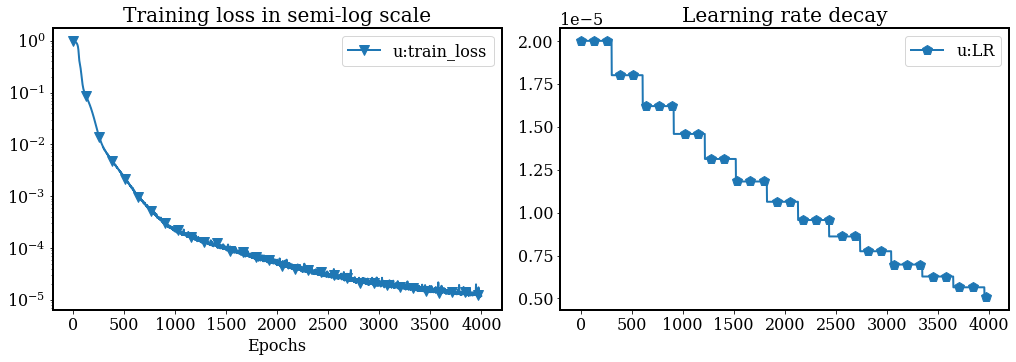

In [20]:
### Training Characteristics
u_lstm.lstm.summary()

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(14,9),constrained_layout=True)

num_epochs_lstm = np.arange(n_epochs_lstm)

ax[0,0].semilogy(num_epochs_lstm,loss_lstm,label='u:train_loss',marker='v',markevery=128)
ax[0,0].set_title('Training loss in semi-log scale')

ax[0,1].plot(num_epochs_lstm,lr_lstm,label='u:LR',marker='p',markevery=128)
ax[0,1].set_title('Learning rate decay')

for i in range(1):
    ax[i,0].legend(); ax[i,1].legend()
    ax[i,0].set_xlabel('Epochs') 
ax[1,1].remove()
ax[1,0].remove()



In [21]:
### Predict using data points not in training set
ky = soln_names[0]
p_num=0
u_test = snap_data[p_num][ky][:,:snap_end[p_num]+1].T
u_shift_test = shifted_snap[p_num][ky][:,:snap_end[p_num]+1].T

if scaling:
    u_test, u_shift_test, _, _ = du.data_scaler(u_test, u_shift_test, u_max, u_min)
    
u_test = np.hstack(( u_test, param_train[p_num]/p_max*np.ones((u_test.shape[0],1)) ))
u_shift_test = np.hstack(( u_shift_test, param_train[p_num]/p_max*np.ones((u_shift_test.shape[0],1)) ))

encoded_u_test = u_autoencoder.encoder(u_test).numpy()
decoded_u_test = u_autoencoder.decoder(encoded_u_test).numpy()



In [22]:

if scaling_lstm:
    encoded_u_test_scaled, _,_,_  = du.data_scaler(encoded_u_test, encoded_u_test, umax_latent, umin_latent)
else:
    encoded_u_test_scaled = encoded_u_test
u_dynamics_test_input, u_dynamics_test_target = tu.split_sequence_multi(encoded_u_test_scaled, lstm_steps)
u_dynamics_test_pred = u_lstm.predict(u_dynamics_test_input)


In [23]:
if scaling_lstm:
    u_dynamics_test_pred_unscaled  = du.scaler_inverse(u_dynamics_test_pred, umax_latent, umin_latent, scaling=scaling_lstm)
else:
    u_dynamics_test_pred_unscaled  = u_dynamics_test_pred

if augment_out:
    decoded_test_pred = u_autoencoder.decoder(u_dynamics_test_pred_unscaled).numpy()[:,:-1]
else:
    decoded_test_pred = u_autoencoder.decoder(u_dynamics_test_pred_unscaled).numpy()
    
pred = {}
pred[soln_names[0]] = du.scaler_inverse(decoded_test_pred, u_max, u_min, scaling=scaling).T


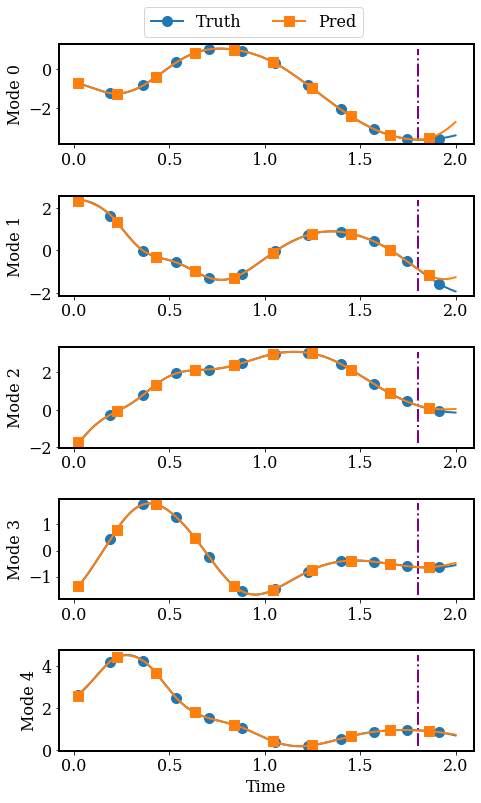

In [24]:
## Compare LSTM predictions in latent space
encoded_truth = encoded_u_test[lstm_steps:,:]; ldim = latent_dim_u; encoded_pred = u_dynamics_test_pred_unscaled
 
num_rows = np.maximum(encoded_truth.shape[1],3)

fig, ax = plt.subplots(nrows=num_rows,ncols=1,figsize=(7,num_rows*2.2),) 
fig.tight_layout()
fig.subplots_adjust(top=0.95)

for i in range(num_rows):
    tt1 = ax[i].plot(times_offline[p_num][lstm_steps:snap_end[p_num]+1],encoded_truth[:,i],
                     label='Truth',marker='o',markevery=43)
    tt2 = ax[i].plot(times_offline[p_num][lstm_steps:snap_end[p_num]+1],encoded_pred[:,i],
                     label='Pred',marker='s',markevery=51)
    ax[i].vlines(x = times_offline[p_num][train_end[p_num]], colors='purple', linestyle='dashdot',
                 ymin = encoded_truth[:,i].min(), ymax = encoded_truth[:,i].max(),)
    ax[i].set_ylabel('Mode %d'%(i))
ax[i].set_xlabel('Time') 
lg = ax[0].legend(ncol=2,bbox_to_anchor=(0.75, 1.45))

# plt.savefig(fig_dir+'Burgers1D_LSTM%d_%s_Re%.1f_AEmodes_n%d_swish_NMSE_epochs%d.png'%(mnum,mnum_ae,Re[p_num],ldim,n_epochs_lstm),dpi=300,bbox_extra_artists=(lg,),bbox_inches='tight')


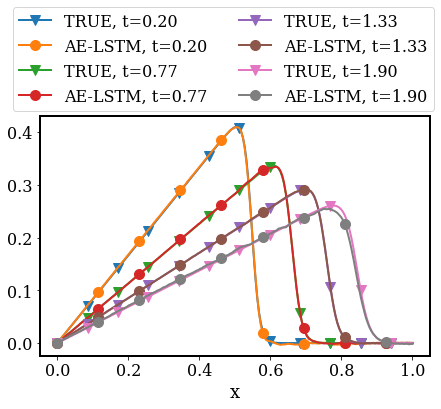

In [25]:
### Visualizing direct reconstruction using true decoder


fig = plt.figure(figsize=(7,6))
ky = soln_names[0]; 
np.random.seed(2021)
fig.tight_layout()
fig.subplots_adjust(top=0.68)


pu.plot_decoded_1d(pred,snap_data[p_num],times_offline[p_num][lstm_steps:],
                   times_offline[p_num][:],nodes,ky,flag='AE-LSTM',tr_end = 0.95) 


# plt.savefig(fig_dir+'Burgers1D_LSTM%d_%s_Re%.1f_recon_n%d_swish_NMSE_epochs%d.png'%(mnum,mnum_ae,Re[p_num],ldim,n_epochs_lstm),dpi=300,bbox_inches='tight')
 